# Turkish Email Spam Detection with KNN

**Goal:** Classify Turkish emails as spam or ham using K-Nearest Neighbors algorithm  
**Dataset:** Turkish Spam V01 (825 emails)  
vs optimize et profesyonel bir görünümü**Method:** KNN with optimized K value (K=3), 70/30 train-test split

## 1. Import Libraries

In [1]:
import string
import csv
import os
from pathlib import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Create output directory
Path("outputs/plots").mkdir(parents=True, exist_ok=True)

## 2. KNN Algorithm Implementation

KNN compares word frequencies using Euclidean distance and classifies based on K nearest neighbors.

In [2]:
def get_count(text):
    """Count word frequencies in text"""
    word_counts = {}
    for word in text.split():
        word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts

def euclidean_difference(test_counts, training_counts):
    """Calculate Euclidean distance between word count vectors"""
    total = 0
    training_copy = training_counts.copy()
    
    for word in test_counts:
        if word in training_copy:
            total += (test_counts[word] - training_copy[word]) ** 2
            del training_copy[word]
        else:
            total += test_counts[word] ** 2
    
    for word in training_copy:
        total += training_copy[word] ** 2
    
    return total ** 0.5

def get_class(neighbors):
    """Determine class based on majority vote"""
    spam_count = sum(1 for label, _ in neighbors if label == "spam")
    ham_count = len(neighbors) - spam_count
    return "spam" if spam_count > ham_count else "ham"

def knn_classifier(training_data, training_labels, test_data, K):
    """KNN classifier implementation"""
    print("Running KNN Classifier...")
    result = []
    
    # Precompute training word counts
    training_counts = [get_count(text) for text in training_data]
    
    for test_text in test_data:
        test_counts = get_count(test_text)
        
        # Calculate distances to all training samples
        distances = [
            (training_labels[i], euclidean_difference(test_counts, training_counts[i]))
            for i in range(len(training_data))
        ]
        
        # Get K nearest neighbors
        distances.sort(key=lambda x: x[1])
        neighbors = distances[:K]
        
        # Predict class
        result.append(get_class(neighbors))
    
    return result

## 3. Load and Preprocess Data

In [3]:
# Load data
data = []
with open("data/trspam.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        label = str(row[-1])
        text = ''.join(row[:-1])
        data.append([text, label])

data = np.array(data[1:-1])  # Remove header and last row
print(f"Total emails: {len(data)}")

# Preprocess
punc = string.punctuation
with open("data/stopwords-tr.txt", "r", encoding="utf-8") as f:
    stopwords = f.read().splitlines()

for record in data:
    text = record[0]
    for char in punc:
        text = text.replace(char, "")
    words = [word.lower() for word in text.split() if word not in stopwords]
    record[0] = " ".join(words)

Total emails: 825


## 4. Train and Test Model

Testing different K values...
Running KNN Classifier...
K=3: Accuracy=81.85%
Running KNN Classifier...
K=3: Accuracy=81.85%
Running KNN Classifier...
K=5: Accuracy=80.65%
Running KNN Classifier...
K=5: Accuracy=80.65%
Running KNN Classifier...
K=7: Accuracy=77.82%
Running KNN Classifier...
K=7: Accuracy=77.82%
Running KNN Classifier...
K=9: Accuracy=76.21%
Running KNN Classifier...
K=9: Accuracy=76.21%
Running KNN Classifier...
K=11: Accuracy=75.40%
Running KNN Classifier...
K=11: Accuracy=75.40%
Running KNN Classifier...
K=15: Accuracy=71.37%
Running KNN Classifier...
K=15: Accuracy=71.37%
Running KNN Classifier...
K=19: Accuracy=68.95%
Running KNN Classifier...
K=19: Accuracy=68.95%
Running KNN Classifier...
K=24: Accuracy=67.34%
Running KNN Classifier...
K=24: Accuracy=67.34%
Running KNN Classifier...
K=30: Accuracy=67.34%

Best K value: 3 with 81.85% accuracy

Running KNN Classifier...
K=30: Accuracy=67.34%

Best K value: 3 with 81.85% accuracy

Running KNN Classifier...
Training s

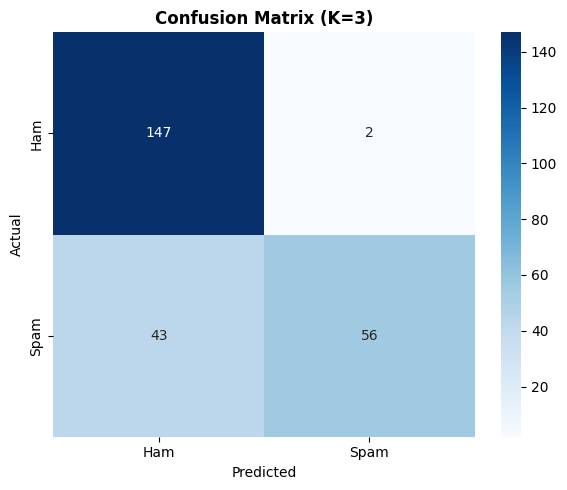


✅ Results saved to outputs/plots/confusion_matrix.png


In [4]:
# Split data
features = data[:, 0]
labels = data[:, 1]
training_data, test_data, training_labels, test_labels = train_test_split(
    features, labels, test_size=0.30, random_state=42, stratify=labels
)

# Try different K values to find the best one
best_k = 24
best_accuracy = 0
print("Testing different K values...")
for k in [3, 5, 7, 9, 11, 15, 19, 24, 30]:
    result = knn_classifier(training_data, training_labels, test_data, k)
    accuracy = accuracy_score(test_labels, result)
    print(f"K={k}: Accuracy={accuracy*100:.2f}%")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"\nBest K value: {best_k} with {best_accuracy*100:.2f}% accuracy")
print("\n" + "="*50)

# Train with best K
K = best_k
result = knn_classifier(training_data, training_labels, test_data, K)
accuracy = accuracy_score(test_labels, result)

# Results
print("="*50)
print(f"Training size: {len(training_data)} | Test size: {len(test_data)}")
print(f"K value: {K}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Correct: {int(accuracy*len(test_data))} | Wrong: {int((1-accuracy)*len(test_data))}")
print("="*50)

# Classification Report
print("\nDetailed Metrics:")
print(classification_report(test_labels, result, target_names=['ham', 'spam']))

# Confusion Matrix
cm = confusion_matrix(test_labels, result, labels=['ham', 'spam'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix (K={K})', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('outputs/plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Results saved to outputs/plots/confusion_matrix.png")